# PySpark SQL

Structure Query Language(SQL) is the language most commonly and widely used to define and express questions about data

### Hive 

> *Abstraction SQL*
> 
> A database abstraction layer (DBAL or DAL) is an application programming interface which unifies the communication between a computer application and databases such as SQL Server, IBM Db2, MySQL, PostgreSQL, Oracle or SQLite.

Many of the SQL abstractions to Big Data processing platforms, such as Spark, are based on the Hive project.

In Hive project, the tables are in actually HDFS, so the HDFS can se access via Sql statement like a DBMS (Heidi). Here  those statements are converted to a sequence of *Java MapReduce operations* to manipulation HDFS and get the result. 

Hive is a platform only read, if well UPDATE is included in HiveqL HDFS is still inmutable, the apparent update is carry on coarse-grained transformations, functions that modify the data only for user, but the data is still inmutable.

Also there are no definitions for primary keys or foreign keys.

`Hive metastore` maps tha *tables* and directory of the location of HDFS, the columns

The metastore is a relational database written to and read by the Hive client, so here the writen a read operation is done.

### Spark SQL Architecture

Spark SQL provide compatibility of HiveSql to RDD base storage (instead to HDFS)

Many of the key characteristics of the core Spark project are in Spark SQL, including lazy evaluation and midquery fault tolerance

Spark sql include:

* *Partial DAG execution*: PDE enables DAGs to be changed and optimized on the fly as information about the data is discovered during processing. The DAG modifications include optimization for performing
joins, handling skew in the data

* *Partition statistics*: Spark SQL maintains statistics about data within
partitions

* *The DataFrame API*

* *Columnar storage*: Spark SQL stores objects in memory using columnar
storage, which organizes data by columns instead of by rows.

It include native support for files Parquet format.

We can define our own functions (UDFs) and HiveSql

<div align="center">
    <img src ="./assets/img/spark-sql.png" width="300" >
</div>

In [1]:
# Pypark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions
import pandas as pd
import numpy as np

Just as the **SparkContext** is the main entry point for an application using the Spark core API, but now we are in stalone mode.

Next, let's initialise a **Spark Session**. 
* A SparkSession object is the entry point to the Spark functionality. 
* When you create the SparkSession object, it initiates a **Spark Application** which all the code for that Session will run on.


In [2]:
spark = SparkSession\
    .builder\
        .appName("spark-sql-app")\
            .enableHiveSupport()\
                .getOrCreate()

Build an app and enable Hive support (to use sql), if exist already we get, otherwise it is created.

In [3]:
# Enable Arrow-based columnar data transfers 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

*Apache Arrow* is an in-memory columnar data format that is used in Spark to efficiently transfer data between JVM and Python processes.

This currently is most beneficial to Python users that work with Pandas/NumPy data. 

To use we need to install `pyarrow`

`Arrow` is available as an optimization when converting a Spark DataFrame to a Pandas DataFrame using `dataframe.toPandas()` and when creating a Spark DataFrame from a Pandas DataFrame with `SparkSession.createDataFrame()`. To use Arrow when executing these calls, users need to first set the Spark configuration `spark.sql.execution.arrow.pyspark.enabled` to `true`.

More information on [arrow pandas](https://spark.apache.org/docs/latest/api/python/user_guide/sql/arrow_pandas.html)

## Spark UI

* We can easily check the current version and get the link of the web interface, **Spark UI**. 
* In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [4]:
spark

## Getting Started with Dataframe

*DataFrame is an abstraction for Spark RDDs*. However, unlike primitive RDDs, DataFrames track their schema and provide native support for many common SQL functions and relational operators.

Dataframes are evaluated in DAG

They use *lazy evaluation* and *providing lineage* and fault tolerance. Also like RDDs, DataFrames support caching and persistence

DataFrames can be created in many different ways, including from the following: 
* from RDD
* JSON file
* A text file, parquet file, or ORC file...
* A table hive
* A table of the external base
* A temporary table in Spark

### From RDD

### From JSON objects 

Multiline is set to false by default

In [27]:
data_user = spark.read.option("multiline","true")\
    .json(path = r'./assets/files/json/data-user-1.json')

In [28]:
data_user.show(5)

+--------------------+---+---------+----------+
|             Address|Age|CellPhone|CustomerId|
+--------------------+---+---------+----------+
| Avenida Iquitos 876| 37|981914173|      1001|
|Avenida San Juan ...| 34|969461498|      1002|
|Avenida Santa Ros...| 42|998535877|      1003|
|Avenida Venezuela...| 44|979577766|      1004|
|Avenida Alfonso U...| 46|958015467|      1005|
+--------------------+---+---------+----------+
only showing top 5 rows



We can read multiple files at a time, with the same schema

In [21]:
data_user_multi = spark.read.option("multiline","true")\
    .json([ r'./assets/files/json/data-user-1.json', r'./assets/files/json/data-user-2.json'])

This read the files and concat them, so the squema must be the same

In [29]:
data_user_multi.printSchema()

root
 |-- Address: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- CellPhone: long (nullable = true)
 |-- CustomerId: long (nullable = true)



We can read all json files from directory. Again, the schema must be the same

In [30]:
data_user_all = spark.read.option("multiline","true")\
    .json(r'./assets/files/json/*.json')

### From csv

Get file from http request

In [35]:
from pyspark import SparkFiles

url = "https://people.sc.fsu.edu/~jburkardt/data/csv/cities.csv"

spark.sparkContext.addFile(url)

In [41]:
cities = spark.read.csv(SparkFiles.get("cities.csv"), header=True, inferSchema= True)

In [42]:
cities.printSchema()

root
 |-- LatD: double (nullable = true)
 |--  "LatM": double (nullable = true)
 |--  "LatS": double (nullable = true)
 |--  "NS": string (nullable = true)
 |--  "LonD": double (nullable = true)
 |--  "LonM": double (nullable = true)
 |--  "LonS": double (nullable = true)
 |--  "EW": string (nullable = true)
 |--  "City": string (nullable = true)
 |--  "State": string (nullable = true)



Another example

We specify that we want to interpret the first line as headers and that we want Spark to try to infer the types of the data.

`Soul.Inc` is fictitious company located in Peru that have like business model `market place`, a virtual place where the sellers can be upload their products in order to be bought by potential users. The products that are uploaded in the app are recorded in a table called `product`. Data about the `sales` and the `users` have their own tables.

A sample of the `products` table is

<center>

| product_id| category_id |current_prices|old_prices|
|------|------|-------|------|
|18006|114|38.35763397762942| 43.97786811127209|
|...|...|...|...|

<center>

In [20]:
products = spark.read.option("inferSchema",True).option("header", True).csv(
    path = './assets/files/products.csv')

In [21]:
products.show(2)

+----------+-----------+------------------+------------------+
|product_id|category_id|    current_prices|        old_prices|
+----------+-----------+------------------+------------------+
|     18006|        114| 38.35763397762942| 43.97786811127209|
|     10912|        105|32.753377759884735|36.723643207569665|
+----------+-----------+------------------+------------------+
only showing top 2 rows



### From parquet

In [10]:
from dotenv import dotenv_values
config = dotenv_values('.env')

In [11]:
dfs = spark.read.parquet(config['PARQUET_PATH'])

In [16]:
dfs

DataFrame[days: tinyint, months: tinyint, years: smallint]

In [12]:
dfs.show(3)

+----+------+-----+
|days|months|years|
+----+------+-----+
|   1|     1| 1990|
|  12|     3| 2000|
|  17|     5| 1995|
+----+------+-----+
only showing top 3 rows



## DataFrame Data Model: Primitive Types

The data model for the DataFrame API is based on the Hive data model.

Datatypes used with DataFrames map directly to their equivalents in Hive. This includes all common primitive types as well as complex, nested types such as the equivalents to lists, dictionaries, and tuples.

<div align="center">
    <img src="./assets/img/dtypes-spark.png" width="400" />
</div>

### Dataframe metadata

In [17]:
# return a list of columns
dfs.columns

['days', 'months', 'years']

In [18]:
# return a list of tuples (name-column, type) 
dfs.dtypes

[('days', 'tinyint'), ('months', 'tinyint'), ('years', 'smallint')]

# Spark operations: transformations vs actions

The operations you can do within a Spark application are divided into two types:

* **Transformations**: 

    * when applied to an DataFrame, they return a new DataFrame created via the transformation.
    * examples: ``filter`` (returns an DataFrame with those elements that pass a condition) and ``sortBy`` (returns a sorted DataFrame). 

* **Actions**: 

    * when applied to an DataFrame, they return a non-DataFrame output.
    * example: ``count`` (returns the number of rows in DataFrame to the Spark driver),  ``collect`` (sends the contents of a DataFrame to the driver).

In [7]:
# `filter` return a dataframe
products_50 = products.filter(functions.col('current_prices') >= 50).filter(
    functions.col('category_id').isNotNull())

In [8]:
# `count` return a aggregation
products_50.count()

12

## Narrow vs. wide transformations

* **Narrow transformation**: 
    * when applied on an RDD, there is no data movement between partitions. 
    * each partition of the parent RDD is used by at most one partition of the child RDD
    * example: ``filter``, ``union``


* **Wide transformation**:

    * requires data movement between partitions, which is known as **shuffle**. 
    * the data is moved across the network and the partitions of the newly-created RDD are based on the data of multiple input partitions.
    * example: ``sortBy``


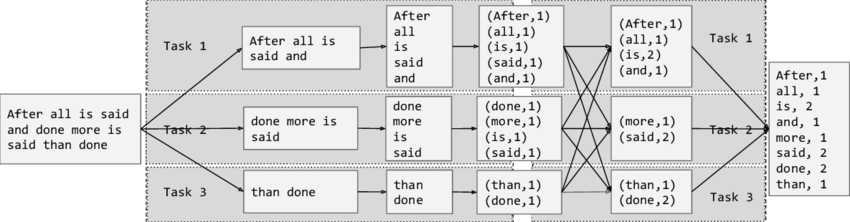

## Basic DataFrame Operations

* `.select(name_of_column)`
* `.drop(name_of_column)`
* `.where()`
* `.count()`
* `.take()`
* `.foreach()`
* `.withColumn(name_of_new_column, expression)`  
  * Adding new column and operations with columns
* `.cast(type)` 
  * Convert type with 
* ...

The `select()`, `drop()`, `filter()`, `where()`, and `distinct()` methods can prune columns or filter rows from a DataFrame. In each case, the results of these operations create a new DataFrame object.

In [23]:
products.show(2)

+----------+-----------+------------------+------------------+
|product_id|category_id|    current_prices|        old_prices|
+----------+-----------+------------------+------------------+
|     18006|        114| 38.35763397762942| 43.97786811127209|
|     10912|        105|32.753377759884735|36.723643207569665|
+----------+-----------+------------------+------------------+
only showing top 2 rows



In [30]:
category_id = products.select('category_id')

In [31]:
category_id.show(2)

+-----------+
|category_id|
+-----------+
|        114|
|        105|
+-----------+
only showing top 2 rows



In [32]:
products_without_category_id = products.drop('category_id') 
products_without_category_id.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- current_prices: double (nullable = true)
 |-- old_prices: double (nullable = true)



In [33]:
products = products.withColumn(
    'discount',
    (functions.col('old_prices') - functions.col('current_prices')) /
    functions.col('old_prices'))

In [34]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- current_prices: double (nullable = true)
 |-- old_prices: double (nullable = true)
 |-- discount: double (nullable = true)



In [35]:
from pyspark.sql.types import IntegerType, BooleanType, DateType, StringType

In [14]:
products.withColumn('category_id_string', products.category_id.cast(StringType())).printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- current_prices: double (nullable = true)
 |-- old_prices: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- category_id_string: string (nullable = true)



In [36]:
products_50 = products\
    .filter(functions.col('current_prices') >= 50)\
        .filter(functions.col('category_id').isNotNull())

In [37]:
products_50.show(5)

+----------+-----------+------------------+------------------+-------------------+
|product_id|category_id|    current_prices|        old_prices|           discount|
+----------+-----------+------------------+------------------+-------------------+
|     18195|        143| 50.36640499390038|53.420829471019545|0.05717665763269678|
|     14059|        183| 55.90109478796007| 59.51755854568664|0.06076297224037701|
|     17370|        190| 52.94775465511651|54.292536358436834|0.02476918179769932|
|     17490|        154|50.229501424233455|54.102159464453244|0.07158047069755585|
|     11785|        126| 52.57626400155483| 54.80887778638559|0.04073452832827989|
+----------+-----------+------------------+------------------+-------------------+
only showing top 5 rows



In [40]:
products_50.select('category_id').distinct().count()

12

### DataFrame Built-in Functions

Numerous functions available in Spark SQL are present in most other common DBMS implementations of SQL. Using the Python Spark API, these built-in functions are available through the *pyspark.sql.functions* module Functions:

<div align="center">
    <img src="./assets/img/spark-functions.png" width="400" />
</div>

In [41]:
from pyspark.sql import functions

In [42]:
products.select(functions.max('discount')).show()

+-------------------+
|      max(discount)|
+-------------------+
|0.14984722643368215|
+-------------------+



Changing the *alias*. This is simialr to `as` in sql

In [43]:
products.select(functions.max('discount').alias('max_discount')).show()

+-------------------+
|       max_discount|
+-------------------+
|0.14984722643368215|
+-------------------+



In [17]:
products.select(functions.max('discount'),
                               functions.min('discount'),
                               functions.avg('discount'),
                               functions.stddev('discount')).show()


+-------------------+--------------------+-------------------+---------------------+
|      max(discount)|       min(discount)|      avg(discount)|stddev_samp(discount)|
+-------------------+--------------------+-------------------+---------------------+
|0.14984722643368215|0.010025509837154084|0.08263149621146539| 0.039747420203879766|
+-------------------+--------------------+-------------------+---------------------+



In [18]:
# show the main statitics
products.describe(['discount', 'old_prices']).show()

+-------+--------------------+------------------+
|summary|            discount|        old_prices|
+-------+--------------------+------------------+
|  count|                 700|               700|
|   mean| 0.08263149621146539| 37.85245207694143|
| stddev|0.039747420203879766|5.6951042361858715|
|    min|0.010025509837154084|30.215020214892444|
|    max| 0.14984722643368215| 62.38072854786709|
+-------+--------------------+------------------+



In [19]:
# Show the products have discount greater or equal to 14% and belong to category 141
products.filter(functions.col('discount') > 0.14).filter(
    functions.col('category_id') == 141).show()


+----------+-----------+------------------+------------------+-------------------+
|product_id|category_id|    current_prices|        old_prices|           discount|
+----------+-----------+------------------+------------------+-------------------+
|     16342|        141|40.876925042455106|47.966318220986054|0.14779940261141872|
|     17733|        141| 34.11837528039679| 39.96083999873853| 0.1462047524157693|
+----------+-----------+------------------+------------------+-------------------+



**groupBy** | **orderBy**

* The *orderBy()* method creates a new DataFrame ordered by the columns specified in the cols argument; ascending is a Boolean argument that defaults to True

* The *groupBy()* method creates a new DataFrame containing the input DataFrame grouped by the column or columns specified in the cols argument


In [20]:
products.groupBy('category_id').agg(
    functions.avg('current_prices').alias(
        'current_prices_sum')).orderBy('current_prices_sum', ascending=True).show(5)

+-----------+------------------+
|category_id|current_prices_sum|
+-----------+------------------+
|        176|30.188591115101982|
|        103| 30.39092755248682|
|        115|30.929346475653542|
|        184|30.932992062869374|
|        111|31.530079909334994|
+-----------+------------------+
only showing top 5 rows



**UDFs: user-defined functions**
* If you want to apply your own function to a column you need to register it as a UDF. 

* UDFs can be used in a number of ways: using `select()`, `withColumn()`, `filter()`, etc.

Let's create a function that extracts the title of the passenger. Names are in the form `Lastname, Title. Firstname`.

Don't work

In [70]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [53]:
map_self = udf(lambda x:x + 5, IntegerType())

In [56]:
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [57]:
from pyspark.sql.types import IntegerType
slen = udf(lambda s: len(s), IntegerType())
@udf
def to_upper(s):
    if s is not None:
        return s.upper()

@udf(returnType=IntegerType())
def add_one(x):
    if x is not None:
        return x + 1

df = spark.createDataFrame([(1, "John Doe", 21)], ("id", "name", "age"))
df.select(slen("name").alias("slen(name)"), to_upper("name"), add_one("age")).show()

Py4JJavaError: An error occurred while calling o308.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 38.0 failed 1 times, most recent failure: Lost task 0.0 in stage 38.0 (TID 32) (DESKTOP-OQ1AEH9.mshome.net executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:188)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:108)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:121)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:162)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:175)
	... 38 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:476)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:429)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3715)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2728)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2728)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2935)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:287)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:326)
	at sun.reflect.GeneratedMethodAccessor63.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:188)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:108)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:121)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:162)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:175)
	... 38 more


**Joins**

syntax: *DataFrame.join(other, on=None, how=None)*
* how: inner, outer, left_outer, right_outer, leftsemi

In [61]:
users = spark.read\
    .option("inferSchema", True)\
        .option("header", True)\
            .csv(path = './assets/files/users.csv')

sales = spark.read\
    .option("inferSchema",True)\
        .option("header", True)\
            .csv(path = './assets/files/sales_normalize.csv')

In [62]:
joinned = users.join(sales, on='user_id', how='inner')

In [69]:
joinned.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- ages: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- sale_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- sales_id: integer (nullable = true)



**windows**

It is similar to other sql 

In [114]:
from pyspark.sql.window import Window

In [23]:
window_category = Window\
    .partitionBy('category_id')\
        .orderBy('discount')

products_with_rank = products.withColumn('rank', functions.percent_rank().over(window_category))

Here we compute the average of products with the 50% higher prices for each category

In [24]:
products_with_rank.filter(functions.col('rank')>0.5).groupBy('category_id')\
    .agg(functions.avg('current_prices')).show(10)

+-----------+-------------------+
|category_id|avg(current_prices)|
+-----------+-------------------+
|        100|   31.1178870981316|
|        101|  35.40804080025515|
|        102| 37.140320938019116|
|        103|  30.76639310722329|
|        104|  36.69445489336907|
|        105|  34.82490326018745|
|        106|  35.42701456648857|
|        107|  35.32405595977966|
|        108|  42.83660698596477|
|        109| 29.900530156809616|
+-----------+-------------------+
only showing top 10 rows



### Hive Queries Using Spark SQL

First we create a template view, then pass any sql statements

In [71]:
# Create a template
products.createOrReplaceTempView("products")

In [72]:
response = spark.sql("show tables")
response.show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         | products|       true|
+---------+---------+-----------+



In [73]:
response = spark.sql("""select * from products limit 5""")

In [74]:
response.show()

+----------+-----------+------------------+------------------+-------------------+
|product_id|category_id|    current_prices|        old_prices|           discount|
+----------+-----------+------------------+------------------+-------------------+
|     18006|        114| 38.35763397762942| 43.97786811127209| 0.1277968754515895|
|     10912|        105|32.753377759884735|36.723643207569665|0.10811197095136135|
|     13871|        133| 35.12974308333188| 37.73788433752289|0.06911201568334153|
|     15350|        148|  35.9508433587602| 39.83733253400052|0.09755897114655603|
|     17798|        165| 27.89263387252526| 32.14430495401886|0.13226825366345432|
+----------+-----------+------------------+------------------+-------------------+



### Saving Dataframe Output

**Writing Data to Files**

Don't work

In [92]:
response.show()

+----------+-----------+------------------+------------------+-------------------+
|product_id|category_id|    current_prices|        old_prices|           discount|
+----------+-----------+------------------+------------------+-------------------+
|     18006|        114| 38.35763397762942| 43.97786811127209| 0.1277968754515895|
|     10912|        105|32.753377759884735|36.723643207569665|0.10811197095136135|
|     13871|        133| 35.12974308333188| 37.73788433752289|0.06911201568334153|
|     15350|        148|  35.9508433587602| 39.83733253400052|0.09755897114655603|
|     17798|        165| 27.89263387252526| 32.14430495401886|0.13226825366345432|
+----------+-----------+------------------+------------------+-------------------+



In [96]:
response.write.options(header='True', delimiter=',')\
    .csv(r'./assets/files/response/', compression='gzip', sep=',', header=True, mode='overwrite' )

Py4JJavaError: An error occurred while calling o475.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:496)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:251)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:839)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 98.0 failed 1 times, most recent failure: Lost task 0.0 in stage 98.0 (TID 79) (DESKTOP-OQ1AEH9.mshome.net executor driver): java.io.IOException: Cannot run program "C:\winutils\bin\winutils.exe": CreateProcess error=216, Esta versión de %1 no es compatible con la versión de Windows que está ejecutando. Compruebe la información de sistema del equipo y después póngase en contacto con el anunciante de software
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:523)
	at org.apache.hadoop.util.Shell.run(Shell.java:482)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:776)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:869)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:852)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:85)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:290)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$16(FileFormatWriter.scala:229)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: CreateProcess error=216, Esta versión de %1 no es compatible con la versión de Windows que está ejecutando. Compruebe la información de sistema del equipo y después póngase en contacto con el anunciante de software
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:386)
	at java.lang.ProcessImpl.start(ProcessImpl.java:137)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 33 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:218)
	... 42 more
Caused by: java.io.IOException: Cannot run program "C:\winutils\bin\winutils.exe": CreateProcess error=216, Esta versión de %1 no es compatible con la versión de Windows que está ejecutando. Compruebe la información de sistema del equipo y después póngase en contacto con el anunciante de software
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:523)
	at org.apache.hadoop.util.Shell.run(Shell.java:482)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:776)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:869)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:852)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:85)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:290)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$16(FileFormatWriter.scala:229)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=216, Esta versión de %1 no es compatible con la versión de Windows que está ejecutando. Compruebe la información de sistema del equipo y después póngase en contacto con el anunciante de software
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:386)
	at java.lang.ProcessImpl.start(ProcessImpl.java:137)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 33 more


### Statistics in PySpark

* Correlation
* Hypothesis testing
  * ChiSquareTest
* Summarizer
* ...

More information in  [ml-statictics](https://spark.apache.org/docs/latest/ml-statistics.html)

In [98]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

Vector Assembler join two columns in one, but this is a array of them 

In [99]:
featureassembler = VectorAssembler(
    inputCols = ['current_prices', 'old_prices'], 
    outputCol="features")

products_transform = featureassembler.transform(products)

In [101]:
products_transform.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[38.3576339776294...|
|[32.7533777598847...|
+--------------------+
only showing top 2 rows



**Correlation**

Compute correlation between two series

In [113]:
# the current_prices and old_prices
print('Matrix correlation:\n',Correlation.corr(products_transform, 'features').head()[0]);

Matrix correlation:
 DenseMatrix([[1.       , 0.9590808],
             [0.9590808, 1.       ]])


### Machine Learning using Spark

The best way to learn how use machine learning in the `PySpark` in with an application

We will build a model that predict the sales of the all sellers. Simultaneously, we build a model that compute the proportion of these that belong to each seller.

The primary squema with we will work is

<div align="center">
    <img src ="./assets/img/soul-schema.png" width="600" >
</div>

## Load files

Load the remaining files(tables) like `users` and `sales_normalize`

In [115]:
users = spark.read.option("inferSchema",True).option("header", True).csv(
    path = './assets/files/users.csv')

sales = spark.read.option("inferSchema",True).option("header", True).csv(
    path = './assets/files/sales_normalize.csv')

The main table that contain the records is `sales_normalize`

In [116]:
sales.show(5)

+----------+-------------+--------+-------+---------+-------------------+--------+
|product_id|   sale_price|quantity|user_id|seller_id|          sale_date|sales_id|
+----------+-------------+--------+-------+---------+-------------------+--------+
|     12545|38.1250714119|       2|   3826|    10519|2017-07-03 04:00:00|   40000|
|     15392|37.5075552788|       2|   3826|    10519|2017-07-03 04:00:00|   40000|
|     18190|31.8646298791|       1|   3826|    10519|2017-07-03 04:00:00|   40000|
|     19564|32.1815737251|       2|   3826|    10519|2017-07-03 04:00:00|   40000|
|     10317|33.2484627343|       2|   3826|    10519|2017-07-03 04:00:00|   40000|
+----------+-------------+--------+-------+---------+-------------------+--------+
only showing top 5 rows



The purpose of the this project is predicts the distribution of the products over the next 2 weeks.

We have this restriction since the products that the sellers `sell` are ordered with 2 weeks in advance

In [117]:
joinned = sales.join(users, on = 'user_id', how = 'inner')

In [118]:
joinned.show(5)

+-------+----------+-------------+--------+---------+-------------------+--------+----+----------+-------------------+
|user_id|product_id|   sale_price|quantity|seller_id|          sale_date|sales_id|ages|department|              dates|
+-------+----------+-------------+--------+---------+-------------------+--------+----+----------+-------------------+
|   3826|     12545|38.1250714119|       2|    10519|2017-07-03 04:00:00|   40000|  30|      Lima|2017-10-23 12:00:00|
|   3826|     15392|37.5075552788|       2|    10519|2017-07-03 04:00:00|   40000|  30|      Lima|2017-10-23 12:00:00|
|   3826|     18190|31.8646298791|       1|    10519|2017-07-03 04:00:00|   40000|  30|      Lima|2017-10-23 12:00:00|
|   3826|     19564|32.1815737251|       2|    10519|2017-07-03 04:00:00|   40000|  30|      Lima|2017-10-23 12:00:00|
|   3826|     10317|33.2484627343|       2|    10519|2017-07-03 04:00:00|   40000|  30|      Lima|2017-10-23 12:00:00|
+-------+----------+-------------+--------+-----

In [62]:
import pandas as pd
import numpy as np

We convert the data to `Pandas DataFrame`

In [133]:
sales_pandas = sales.toPandas()
products_pandas = products.toPandas()

In [195]:
sales_products_pandas = sales_pandas.merge(products_pandas, on = 'product_id')

In [191]:
variable = 'category_id' #variable

In [196]:
sales_products_2weeks = sales_products_pandas.groupby(
    [pd.Grouper(key = 'sale_date', freq='2w'), variable])

products_by_2w = sales_products_2weeks.quantity.agg('sum').unstack()
total_by_2w = products_by_2w.sum(axis=1)

In [197]:
dist_products_by_2w = products_by_2w.div(total_by_2w, axis='index')

`dist_products_by_2w`
* With this table we create the `features` and `target` 

Target

In [198]:
dist_products_by_2w_stack = dist_products_by_2w.stack()
dist_products_by_2w_stack.name = 'target'
data_target = dist_products_by_2w_stack.reset_index()

Features

In [199]:
dist_products_by_2w_shift = dist_products_by_2w.shift(2)
dist_products_by_2w_shift_stack = dist_products_by_2w_shift.stack()
dist_products_by_2w_shift_stack.name = "feature"
data_feature = dist_products_by_2w_shift_stack.reset_index()

Data Complete

In [200]:
data_complete = data_target.merge(data_feature, on = ['sale_date', variable])

Add some features

In [202]:
group_by_variable =products_pandas.groupby(variable)
variable_by_count = group_by_variable.product_id.agg(lambda x:len(np.unique(x)))
variable_by_count.name = "portfolio"
variable_count = variable_by_count.reset_index()

Join the new features

In [203]:
data_to_algmoritm = data_complete.merge(variable_count, on = variable)

In [208]:
data_total = data_to_algmoritm.sort_values(by = 'sale_date')
data_total.reset_index(inplace = True, drop=True)

In [210]:
data_total_spark = spark.createDataFrame(data_total)

In [259]:
data_total_spark = data_total_spark.withColumn('date', functions.to_date('sale_date'))

In [260]:
from pyspark.ml.feature import VectorAssembler
featureassembler=VectorAssembler(inputCols=["feature","portfolio"],outputCol="Independent Features")

In [261]:
output = featureassembler.transform(data_total_spark)

In [273]:
date_treshold = '2022-05-08'

In [274]:
data_total_spark_traning = output.filter(functions.col('sale_date')<f"{date_treshold}")
data_total_spark_testing = output.filter(functions.col('sale_date')==f"{date_treshold}")

In [279]:
print("Size of train:",data_total_spark_traning.count())
print("Size of test:",data_total_spark_testing.count())

Size of train: 12104
Size of test: 96


In [271]:
dates_test = data_total.sale_date.unique()[-5:-1]

In [280]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor

In [281]:
regressor=RandomForestRegressor(featuresCol='Independent Features', labelCol='target')
regressor=regressor.fit(data_total_spark_traning)

In [282]:
predict = regressor.transform(data_total_spark_testing)

In [284]:
predictPandas = predict.toPandas()

c:\Users\LENOVO\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [287]:
gd = predictPandas[['prediction', 'target']]*total_by_2w[date_treshold].copy()

In [288]:
gd.eval("abs(target - prediction)").quantile([0, 0.25, 0.5, 0.75, 0.9, 1])

0.00     0.003371
0.25     1.601855
0.50     4.203612
0.75     6.362380
0.90     7.995418
1.00    13.687902
dtype: float64

<AxesSubplot:>

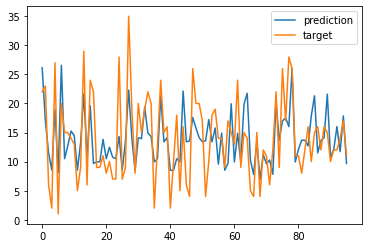

In [289]:
gd.plot()

### Accessing Spark SQL

Connection with MariaDB

This is part of the [`JDBC to Others Databases`](https://spark.apache.org/docs/latest/sql-data-sources-jdbc.html)

> Recall
> 
> JDBC means $\text{Java}^{\text{TM}}$ $\text{DataBase}$ $\text{Connection}$

We can read data from the other databases like *MariaDB*, *MS Sql*, *Oracle*, *PostgreSQL*. For Each one we must download its connector

For *MariaBD*
1. Downloading the connector from https://dev.mysql.com/downloads/connector/j/?os=26 (mysql-connector-j-8.0.31.tar.gz)
2. Decompress in a folder.
3. The path where is the file will be included in `config['CONN_MYSQL_JAR']`

In [5]:
from dotenv import dotenv_values

In [6]:
config = dotenv_values('.env')

We start a new session with spark jars  built using the connector 

In [21]:
maria_db = SparkSession \
       .builder.config("spark.jars", config['CONN_MYSQL_JAR'])\
       .master("local")\
       .appName("PySpark")\
       .getOrCreate()

Using the connector we connect on it using all the setting, the URI, table name, user name, password, and so on. 

In [22]:
country = maria_db.read \
         .format("jdbc") \
         .option("url", config['CONN_MYSQL_CLIENT'])\
         .option("driver", "com.mysql.jdbc.Driver") \
         .option("dbtable", "country") \
         .option("user", config['USER']) \
         .option("password", config['PASSWORD']) \
         .load()

In [17]:
country.show(2)

+----+-----------+-------------+--------------------+-----------+---------+----------+--------------+-------+------+--------------------+--------------------+-------------+-------+-----+
|Code|       Name|    Continent|              Region|SurfaceArea|IndepYear|Population|LifeExpectancy|    GNP|GNPOld|           LocalName|      GovernmentForm|  HeadOfState|Capital|Code2|
+----+-----------+-------------+--------------------+-----------+---------+----------+--------------+-------+------+--------------------+--------------------+-------------+-------+-----+
| ABW|      Aruba|North America|           Caribbean|     193.00|     null|    103000|          78.4| 828.00|793.00|               Aruba|Nonmetropolitan T...|      Beatrix|    129|   AW|
| AFG|Afghanistan|         Asia|Southern and Cent...|  652090.00|     1919|  22720000|          45.9|5976.00|  null|Afganistan/Afqane...|     Islamic Emirate|Mohammad Omar|      1|   AF|
+----+-----------+-------------+--------------------+-----------+

In [23]:
city = maria_db.read \
         .format("jdbc") \
         .option("url", config['CONN_MYSQL_CLIENT'])\
          .option("driver", "com.mysql.jdbc.Driver") \
         .option("dbtable", "city") \
         .option("user", config['USER']) \
         .option("password", config['PASSWORD']) \
         .load()

We can use join, similar to join in sql

In [28]:
# Due to the code is repeat afet the joining we drop one of them
joinned = city.join(country, city.CountryCode == country.Code, 'inner').drop(functions.col('code2'))

More kind of the join, like left, outer, ... in [Spark by examples](https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/)

We can write in the database from a dataframe. 

Suppose we already have a dataframe and we want to save it in a MariaDB.

so, we can save using `.write` and the pass the severals setting 

In [30]:
joinned.write\
    .format("jdbc") \
         .option("url", config['CONN_MYSQL_CLIENT'])\
          .option("driver", "com.mysql.jdbc.Driver")\
         .option("dbtable", "joined_table")\
         .option("user", config['USER'])\
         .option("password", config['PASSWORD'])\
         .save()

https://www.projectpro.io/recipes/read-data-from-postgresql-pyspark

https://spark.apache.org/docs/latest/sql-data-sources-jdbc.html

https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/

https://spark.apache.org/docs/2.2.0/sql-programming-guide.html

https://github.com/krishnaik06/Pyspark-With-Python/blob/main/Tutorial%206-Example%20Of%20Pyspark%20ML.ipynb